In [ ]:
# default_exp pseudodata

# pseudodata

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export
from fastcore.all import store_attr
from typing import Callable, Tuple, Union, List
import numpy as np
import pandas as pd

In [ ]:
# export
class PseudoData():
    def __init__(self, func:Callable[[int],np.ndarray], targ:Union[float,int]): store_attr()
    def __getitem__(self, i:int) -> Tuple[np.ndarray,np.ndarray]: self.sample(1)
    def sample(self, n:int) -> Tuple[np.ndarray,np.ndarray,None]:
        return self.func(n).astype('float32'),self.targ*np.ones((n,1)).astype('float32'),None
    def get_df(self, n:int) -> pd.DataFrame:
        d = self.sample(n)
        if d[2] is None: d = d[:2]
        df = pd.DataFrame(np.hstack(d))
        df.rename(columns={df.columns[-1]:'gen_target'}, inplace=True)
        return df

In [ ]:
d = PseudoData(lambda x: np.random.normal(0,1,(x,3)), 0)
df = d.get_df(10)
assert df.values.shape == (10,4)
df.head()

,0,1,2,gen_target
0,-1.973458,-0.396431,0.793714,0.0
1,-1.079351,-0.500465,-0.539663,0.0
2,0.035073,-1.557182,-0.965231,0.0
3,-1.225256,0.973952,-1.408443,0.0
4,-0.452827,0.462017,0.881532,0.0


## INFERNO paper

In [ ]:
# export
class _PaperData():
    def __init__(self, mu:List[float], conv:List[List[float]], r:float, l:float):
        store_attr(but=['mu', 'r'])
        self.r = np.array([r,0])
        self.mu = np.array(mu)
        
    def __call__(self, n:int) -> np.ndarray:
        return np.hstack((np.random.multivariate_normal(self.mu+self.r, self.conv, n),
                          np.random.exponential(1/self.l, size=n)[:,None]))

In [ ]:
# export
paper_sig = _PaperData(mu=[0,0], conv=[[1,0],[0,1]], r=0, l=2)

In [ ]:
s0 = paper_sig(2)
print(s0)
assert s0.shape == (2,3)

[[-0.90801508  0.30009581  0.09278731]
 [ 0.40967515  0.14293755  2.40033859]]


In [ ]:
paper_sig1 = _PaperData([0,0], [[1,0],[0,1]], 0, 2)
paper_sig1.r[0] += 1000

In [ ]:
s1 = paper_sig(2)
print(s1)
assert s1[0,0] > s0[0,0]

[[ 0.23523359  0.93299504  0.31385965]
 [-0.21883406 -0.71766427  0.60523538]]


In [ ]:
# export
paper_bkg_bm0 = _PaperData(mu=[2,0], conv=[[5,0],[0,9]], r=0, l=3)

### Check

In [ ]:
n=1000
df = PseudoData(paper_sig, 1).get_df(n).append(PseudoData(paper_bkg_bm0, 0).get_df(n), ignore_index=True)
df

,0,1,2,gen_target
0,0.787033,-0.893879,0.415773,1.0
1,-0.111509,-0.231453,0.798782,1.0
2,0.884714,0.323264,0.304551,1.0
3,-1.121566,0.688244,0.128769,1.0
4,2.210901,-0.494625,0.092700,1.0
...,...,...,...,...
1995,1.676995,-8.898761,0.094973,0.0
1996,2.475347,-6.536939,0.011122,0.0
1997,-0.388770,-2.981233,0.150563,0.0
1998,3.840080,2.159555,0.284163,0.0


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


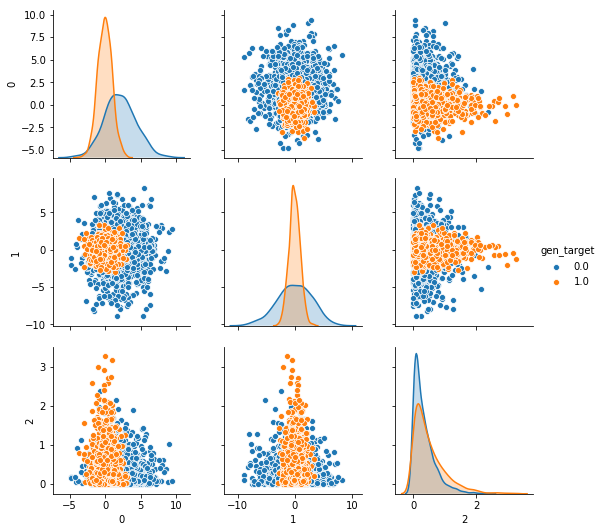

In [ ]:
import seaborn as sns
sns.pairplot(df, hue='gen_target', vars=[f for f in df.columns if f != 'gen_target'])